In [110]:
!pwd

/home/nicolasf/research/Smart_Ideas/code/GCM-validations/notebooks


In [88]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr

### plotting 
from matplotlib import pyplot as plt
import seaborn as sns

In [89]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [90]:
import climpred

In [91]:
dpath = pathlib.Path('/media/nicolasf/END19101/data/climate_indices')

In [92]:
indice_name = 'Z1'

In [93]:
# SAM_obs = pd.read_csv(dpath.joinpath("SAM_ERA5/SAM_ERA5.csv"), index_col=0, parse_dates=True) 

In [94]:
ind_obs = pd.read_csv(dpath.joinpath(f"{indice_name}_ERA5/{indice_name}_ERA5.csv"), index_col=0, parse_dates=True) 

In [95]:
ind_obs = ind_obs.to_xarray()

In [96]:
ind_ecmwf = pd.read_csv(dpath.joinpath(f"{indice_name}_GCM/{indice_name}_ECMWF.csv"), index_col=0, parse_dates=True, header=[0,1]) 

In [97]:
ind_ecmwf.head()

Z1                                                  
                   0         1         2         3         4         5
init_time                                                             
1981-01-01  0.101982 -0.672912 -0.575385 -0.867817 -0.598021  0.127873
1981-02-01 -0.800173 -0.732043 -0.513108 -0.438799 -1.247920 -1.051749
1981-03-01 -0.131039 -1.715012  0.195541 -0.185029 -0.803266  0.133680
1981-04-01  0.287778 -0.354028  0.000842 -0.088250 -0.061716  0.851806
1981-05-01 -1.578242  0.401484  1.472678  0.015335 -0.019461 -0.096879

In [98]:
ind_ecmwf_xr = {}

In [99]:
ind_ecmwf_xr['init'] = (('init'), ind_ecmwf.index.to_pydatetime()) 

In [100]:
ind_ecmwf_xr['lead'] = (('lead'), np.arange(0, 6))

In [101]:
ind_ecmwf_xr[indice_name] = (('init','lead'), ind_ecmwf.values)

In [102]:
ind_ecmwf_xr = xr.Dataset(ind_ecmwf_xr) 

In [103]:
ind_ecmwf_xr['lead'].attrs = {'units':'months'}

In [104]:
hindcast = climpred.HindcastEnsemble(ind_ecmwf_xr)

In [105]:
hindcast = hindcast.add_observations(ind_obs)

In [106]:
acc = hindcast.verify(metric='pearson_r', comparison='e2o', dim='init', alignment='maximize', reference='persistence')

Text(0, 0.5, 'Anomaly Correlation Coefficient')

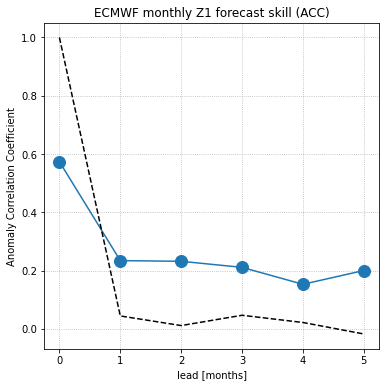

In [107]:
f, ax = plt.subplots(figsize=(6,6))
acc.sel(skill='initialized')[indice_name].plot(marker='o', markersize=12, ax=ax)
acc.sel(skill='persistence')[indice_name].plot(color='k', linestyle='--', ax=ax)
ax.grid(ls=':') 
ax.set_title(f'ECMWF monthly {indice_name} forecast skill (ACC)')
ax.set_ylabel('Anomaly Correlation Coefficient')


In [108]:
result = []
for label, group in ind_ecmwf_xr.groupby('init.month'):
    hindcast = climpred.HindcastEnsemble(group)
    hindcast = hindcast.add_observations(ind_obs)
    hindcast.load()
    skill = hindcast.verify(metric='acc', comparison='e2o', dim='init', alignment='maximize')
    result.append(skill)

result = xr.concat(result, dim='month')
result['month'] = np.arange(12) + 1

In [109]:
result

<xarray.Dataset>
Dimensions:  (lead: 6, month: 12)
Coordinates:
  * lead     (lead) int64 0 1 2 3 4 5
    skill    <U11 'initialized'
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Z1       (month, lead) float64 0.5452 0.1765 0.5334 ... -0.01601 0.2384

In [25]:
result = result.to_dataframe()[indice_name].unstack()

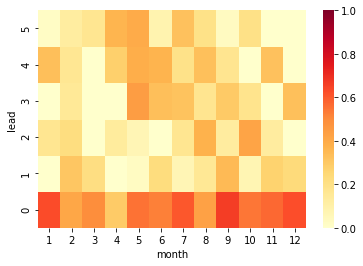

In [28]:
ax = sns.heatmap(result, cmap='YlOrRd', vmin=0, vmax=1)
plt.gca().invert_yaxis()

In [31]:
result.loc[1,:]

month
1    -0.034203
2     0.309988
3     0.218201
4    -0.016950
5     0.030732
6     0.229368
7     0.069689
8     0.158868
9     0.348952
10    0.072657
11    0.272245
12    0.236194
Name: 1, dtype: float64